In [1]:
from functions_homework1 import *

import warnings
warnings.filterwarnings("ignore")

global demand_df,c_jt_dic,PARAMS,alpha, Temp_t, data

# Problem 1
## 1(a)
In this part I reg ln(s_jt/s_0t) to X_jt,p_jt, I_Diet, I_Regular. This means I treat xi_j as noise in regression.

The estimations are:

const      -3.044239
price      -1.626102
sugar       1.528062
caffeine    1.445800
Diet        0.603640
Regular    -3.647879

In [2]:
Dic_para_q1 = dict()
Dic_para_q2q3 = dict()
# Load the data
data = pd.read_csv('product_data.csv')
data = prepare_data(data)

# Prepare the design matrix X and dependent variable y
X = data[['price', 'sugar', 'caffeine', 'Diet', 'Regular']]
# X = sm.add_constant(X)  # Add a constant term to the model
y = data['log_odds']

# Fit the model
model = sm.OLS(y, X)
model_results = model.fit()

# Print the results
print(model_results.summary())

params_ols = get_parameters(model_results, nested=False, print_results=False)
Dic_para_q1['OLS'] = params_ols

                            OLS Regression Results                            
Dep. Variable:               log_odds   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1912.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:37:09   Log-Likelihood:                -1305.2
No. Observations:                1000   AIC:                             2620.
Df Residuals:                     995   BIC:                             2645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price         -1.6261      0.021    -77.352      0.0

## 1(a)-2 
In this part I reg ln(s_jt/s_0t) to X_jt,p_jt, I_Diet, I_Regular and 9 dummies for each j (drop ID_1). This means I treat xi_j as fixed within periods in regression.

In [3]:
ID_dummies = pd.get_dummies(data['product_ID'], prefix='ID').astype(int)
ID_dummies = ID_dummies.drop('ID_1', axis=1)

X = pd.concat([X, ID_dummies], axis=1)

y = data['log_odds']

# Fit the model
model = sm.OLS(y, X)
model_results = model.fit()

# Print the results
params_ols_fixed_effect = get_parameters(
    model_results, nested=False, print_results=True)
Dic_para_q1['OLS_fixed_effect'] = params_ols_fixed_effect

alpha (price): -1.6239
beta1 (sugar): 1.5230
beta2 (caffeine): 1.4450
gamma_D (Diet): -2.3990
gamma_R (Regular): -5.5584


## 1(b)


In [4]:
# Construct instruments
data['Z1'] = data['caffeine_extract_price'] * data['caffeine']
data['Z2'] = data['corn_syrup_price'] * data['sugar']

# Prepare the data for IV regression

X = data[['sugar', 'caffeine', 'Diet', 'Regular', 'price']]
instruments = data[['sugar', 'caffeine', 'Diet', 'Regular', 'Z1', 'Z2']]
y = data['log_odds']

# Perform 2SLS estimation
iv_model = IV2SLS(y, X, instruments)
iv_results = iv_model.fit()

# Print the results
params_IV = get_parameters(iv_results, nested=False, print_results=True)
Dic_para_q1['IV'] = params_IV

alpha (price): -1.2405
beta1 (sugar): 1.3486
beta2 (caffeine): 1.3318
gamma_D (Diet): -2.6493
gamma_R (Regular): -6.5599


## 1(c)
Let $M=\sum_{k\neq j} exp(\delta_k)+1$, then $\frac{\partial s_{jt}}{\partial p_{jt}}=\frac{Mexp(\delta_{jt})}{(M+exp(\delta_{jt}))^2}\alpha=\alpha s_{jt}(1-s_{jt})$

In [5]:
def own_price_derivative(alpha, s_jt):
    return alpha * s_jt * (1 - s_jt)

# Function to calculate own-price elasticity


def own_price_elasticity(alpha, p_jt, s_jt):
    return alpha * p_jt * (1 - s_jt)


def own_PD_PE(df, params_ols):
    """take alpha and call the function, return the results"""
    data = df.copy()
    # Calculate own-price derivatives and elasticities
    alpha = params_ols['alpha']
    data['own_price_derivative'] = own_price_derivative(
        alpha, data['market_share'])
    data['own_price_elasticity'] = own_price_elasticity(
        alpha, data['price'], data['market_share'])

    # Calculate mean elasticities for Regular and Diet drinks
    mean_elasticity_regular = data[data['nest']
                                   == 'Regular']['own_price_elasticity'].mean()
    mean_elasticity_diet = data[data['nest'] ==
                                'Diet']['own_price_elasticity'].mean()

    print(
        f"Mean own-price elasticity for Regular drinks: {mean_elasticity_regular:.4f}")
    print(
        f"Mean own-price elasticity for Diet drinks: {mean_elasticity_diet:.4f}")

    return [mean_elasticity_regular, mean_elasticity_diet,data]


[mean_elasticity_regular, mean_elasticity_diet,data] = own_PD_PE(data, params_IV)
Dic_para_q2q3['own_elasticity_regular_1c'] = mean_elasticity_regular
Dic_para_q2q3['own_elasticity_diet_1c'] = mean_elasticity_diet

# # * Plot histograms of elasticities
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# data[data['nest'] == 'Regular']['own_price_elasticity'].hist(bins=20)
# plt.title('Own-Price Elasticities - Regular Drinks')
# plt.xlabel('Elasticity')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# data[data['nest'] == 'Diet']['own_price_elasticity'].hist(bins=20)
# plt.title('Own-Price Elasticities - Diet Drinks')
# plt.xlabel('Elasticity')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

Mean own-price elasticity for Regular drinks: -3.6948
Mean own-price elasticity for Diet drinks: -2.6162


## 1(d)
Similarly $\frac{\partial s_{jt}}{\partial p_{1t}}=-\alpha s_{jt}s_{1t}$

In [6]:
# Function to calculate cross-price elasticity
def cross_price_derivative(alpha, s_jt, s_it):
    return -alpha * s_jt * s_it

def cross_price_elasticity(alpha, p_1t, s_jt, s_1t):
    return -alpha * p_1t * s_jt


def cross_PD_PE(df,params_ols):
    data=df.copy()
    alpha = params_ols['alpha']

    # Get product 1's market share for each time period
    product_1_share = data[data['product_ID'] == 1].set_index('t')['market_share']

    # Calculate cross-price derivatives and elasticities
    data['cross_price_derivative'] = data.apply(lambda row: cross_price_derivative(alpha, row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    data['cross_price_elasticity'] = data.apply(lambda row: cross_price_elasticity(alpha, data.loc[(data['product_ID'] == 1) & (data['t'] == row['t']), 'price'].values[0],
                                                row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    # Calculate mean cross-price elasticities
    mean_cross_elasticity_diet = data[(data['nest'] == 'Diet') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()
    mean_cross_elasticity_regular = data[(data['nest'] == 'Regular') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()

    print(
        f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet:.4f}")
    print(
        f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular:.4f}")
    return [mean_cross_elasticity_diet,mean_cross_elasticity_regular,data]

[mean_cross_elasticity_diet,mean_cross_elasticity_regular,data]= cross_PD_PE(data,params_IV)
Dic_para_q2q3['cross_elasticity_regular_1d'] = mean_cross_elasticity_regular
Dic_para_q2q3['cross_elasticity_diet_1d'] = mean_cross_elasticity_diet

# * Plot histograms of cross-price elasticities
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# data[(data['nest'] == 'Diet') & (data['product_ID'] != 1)
#      ]['cross_price_elasticity'].hist(bins=20)
# plt.title('Cross-Price Elasticities - Product 1 vs Diet Drinks')
# plt.xlabel('Elasticity')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# data[(data['nest'] == 'Regular') & (data['product_ID'] != 1)
#      ]['cross_price_elasticity'].hist(bins=20)
# plt.title('Cross-Price Elasticities - Product 1 vs Regular Drinks')
# plt.xlabel('Elasticity')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

Mean cross-price elasticity between product 1 and Diet sodas: 0.1806
Mean cross-price elasticity between product 1 and Regular sodas: 0.3401


## 1(e)
Use the formula that $\frac{\partial s_{jt}}{\partial p_{it}}=-\alpha s_{jt}s_{it}$

In [7]:
def generate_jacobian(time_period, data, params):
    """
    Generate the Jacobian matrix of price derivatives for a given time period.
    I Do need market_share column in the data pd
    Returns: np.array like Jacobian matrix of price derivatives.
    """
    alpha = params['alpha']
    # Filter data for the given time period
    period_data = data[data['t'] == time_period]
    n_products = len(period_data)
    shares = period_data['market_share'].values

    # Initialize the Jacobian matrix
    jacobian = np.zeros((n_products, n_products))

    # Fill in the Jacobian matrix
    for i in range(n_products):
        for j in range(n_products):
            if i == j:
                # Own-price derivative
                s_it = shares[i]
                jacobian[i, i] = own_price_derivative(alpha, s_it)
            else:
                # Cross-price derivative
                s_jt = shares[j]
                s_it = shares[i]
                jacobian[i, j] = cross_price_derivative(alpha, s_jt,  s_it)

    return jacobian


def print_jacobian(data, params_IV):
    # Generate Jacobian for the last time period
    last_period = data['t'].max()
    jacobian_last_period = generate_jacobian(last_period, data, params_IV)
    print(f"Jacobian matrix for period {last_period}:")
    print(np.round(jacobian_last_period, 3))


data_Q1=data.copy()
print_jacobian(data, params_IV)

Jacobian matrix for period 100:
[[-0.073  0.     0.001  0.002  0.019  0.003  0.035  0.008  0.003  0.003]
 [ 0.    -0.002  0.     0.     0.     0.     0.001  0.     0.     0.   ]
 [ 0.001  0.    -0.013  0.     0.003  0.     0.006  0.001  0.001  0.   ]
 [ 0.002  0.     0.    -0.025  0.006  0.001  0.011  0.002  0.001  0.001]
 [ 0.019  0.     0.003  0.006 -0.229  0.012  0.135  0.029  0.012  0.011]
 [ 0.003  0.     0.     0.001  0.012 -0.047  0.022  0.005  0.002  0.002]
 [ 0.035  0.001  0.006  0.011  0.135  0.022 -0.306  0.053  0.022  0.02 ]
 [ 0.008  0.     0.001  0.002  0.029  0.005  0.053 -0.108  0.005  0.004]
 [ 0.003  0.     0.001  0.001  0.012  0.002  0.022  0.005 -0.049  0.002]
 [ 0.003  0.     0.     0.001  0.011  0.002  0.02   0.004  0.002 -0.043]]


## Compare estimations from different methods

In [8]:
pd.DataFrame(Dic_para_q1)

,OLS,OLS_fixed_effect,IV
alpha,-1.626102,-1.623944,-1.240471
beta1,1.528062,1.522991,1.348568
beta2,1.445800,1.444985,1.331827
gamma_D,-2.440599,-2.399023,-2.649342
gamma_R,-6.692118,-5.558367,-6.559863


# Problem 2

## 2(a)

In [9]:
Dic_para_q2 = dict()

In [10]:
# Load the data
data = pd.read_csv('product_data.csv')
data = prepare_data(data)
data['group_share'] = data.groupby(
    ['t', 'nest'])['market_share'].transform('sum')
data['within_group_share'] = data['market_share'] / data['group_share']
data['log_within_share'] = np.log(data['within_group_share'])

# Prepare the design matrix X and dependent variable y
# Create instruments
data['Z1'] = data['caffeine_extract_price'] * data['caffeine']
data['Z2'] = data['corn_syrup_price'] * data['sugar']
exog_list = ['sugar', 'caffeine', 'Diet', 'Regular', 'log_within_share']
X = data[['price']+exog_list]
y = data['log_odds']
instruments = data[['Z1', 'Z2']+exog_list]

# Fit the model
model = sm.OLS(y, X)
model_results = model.fit()
nest_params_ols = get_parameters(
    model_results, nested=True, print_results=False)
Dic_para_q2['nest_OLS'] = nest_params_ols

# Perform 2SLS estimation
iv_model = IV2SLS(y, X, instruments)
iv_results = iv_model.fit()
nest_params_IV = get_parameters(iv_results, nested=True, print_results=False)
Dic_para_q2['nest_params_IV'] = nest_params_IV

## 2(b)

In [11]:
[Nest_mean_elasticity_regular, Nest_mean_elasticity_diet,data] = own_PD_PE(data, nest_params_IV)
Dic_para_q2q3['own_Nest_elasticity_regular_2b'] = Nest_mean_elasticity_regular
Dic_para_q2q3['own_Nest_elasticity_diet_2b'] = Nest_mean_elasticity_diet

Mean own-price elasticity for Regular drinks: -1.1759
Mean own-price elasticity for Diet drinks: -0.8326


## 2(c)

In [12]:
[Nest_mean_cross_elasticity_regular, Nest_mean_cross_elasticity_diet,data] = cross_PD_PE(data, nest_params_IV)
Dic_para_q2q3['cross_Nest_elasticity_regular_2c'] = Nest_mean_cross_elasticity_regular
Dic_para_q2q3['cross_Nest_elasticity_diet_2c'] = Nest_mean_cross_elasticity_diet

Mean cross-price elasticity between product 1 and Diet sodas: 0.0575
Mean cross-price elasticity between product 1 and Regular sodas: 0.1082


## 2(d)

In [13]:
part_2= pd.DataFrame(Dic_para_q2)
part_1= pd.DataFrame(Dic_para_q1)
merge_params_all = pd.concat([part_1,part_2],axis=1)
wanted_lis = [x for x in merge_params_all.columns if 'IV' in x]
merge_params_all[wanted_lis].round(3)

,IV,nest_params_IV
alpha,-1.240,-0.395
beta1,1.349,0.388
beta2,1.332,0.398
gamma_D,-2.649,2.532
gamma_R,-6.560,1.918
sigma,NaN,0.780


In [14]:
pd.DataFrame([Dic_para_q2q3]).T

,0
own_elasticity_regular_1c,-3.694777
own_elasticity_diet_1c,-2.616178
cross_elasticity_regular_1d,0.340054
cross_elasticity_diet_1d,0.180621
own_Nest_elasticity_regular_2b,-1.175896
own_Nest_elasticity_diet_2b,-0.832623
cross_Nest_elasticity_regular_2c,0.057484
cross_Nest_elasticity_diet_2c,0.108225


## 2(e)

In [15]:
print_jacobian(data, nest_params_IV)

Jacobian matrix for period 100:
[[-0.023  0.     0.     0.001  0.006  0.001  0.011  0.002  0.001  0.001]
 [ 0.    -0.001  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.004  0.     0.001  0.     0.002  0.     0.     0.   ]
 [ 0.001  0.     0.    -0.008  0.002  0.     0.004  0.001  0.     0.   ]
 [ 0.006  0.     0.001  0.002 -0.073  0.004  0.043  0.009  0.004  0.003]
 [ 0.001  0.     0.     0.     0.004 -0.015  0.007  0.001  0.001  0.001]
 [ 0.011  0.     0.002  0.004  0.043  0.007 -0.097  0.017  0.007  0.006]
 [ 0.002  0.     0.     0.001  0.009  0.001  0.017 -0.034  0.002  0.001]
 [ 0.001  0.     0.     0.     0.004  0.001  0.007  0.002 -0.015  0.001]
 [ 0.001  0.     0.     0.     0.003  0.001  0.006  0.001  0.001 -0.014]]


## 3


## 3(a)
I still use MNL demand for this part, since outcomes for NestLogit seems weird. 

The FOC is $s_{jt}+(P_{jt}-c_{jt})\frac{\partial s_{jt}}{\partial p_{jt}}=0$

If we believe the market data represents the Nash Equilibrium status, then mutual best response means $\frac{\partial s_{jt}}{\partial p_{jt}}$ is evaluated when $s_{-j,t}$ lies in the EQM level: the point estimate we get is also a function evaluated at EQM.


so we can estimate $\hat c_jt=P_{jt}+s_{jt}/(\frac{\partial s_{jt}}{\partial p_{jt}})$



The can query by own_price_derivative(alpha, s_jt), but actually is stored in data

In [16]:
def calc_cost_Lerner(data):
    data['middle']=data['market_share']/data['own_price_derivative']
    data['cost']=data['price']+data['middle']
    data['middle_2']=data['price']-data['cost']
    data['Lerner']=data['middle_2']/data['price']
    data=data.drop('middle',axis=1).drop('middle_2',axis=1)
    return data

data_Nest=calc_cost_Lerner(data)
# for mean Lerner I think it's mean over time
part_Q2=data_Nest.groupby('product_ID').agg({'Lerner':np.mean})

#seems weird so I go back and check whether derivatives got from MNL makes sense
data_ML=calc_cost_Lerner(data_Q1)  
part_Q1 = data_ML.groupby('product_ID').agg({'Lerner':np.mean})

part_Q2['Lerner_MultiNomialLogit']=part_Q1
part_Q2['Lerner_NestedLogit']=part_Q2['Lerner']
part_Q2=part_Q2.drop('Lerner',axis=1)
part_Q2

,Lerner_MultiNomialLogit,Lerner_NestedLogit
product_ID,,
1,0.424900,1.335075
2,0.409020,1.285180
3,0.406436,1.277059
4,0.417436,1.311623
5,0.431794,1.356736
6,0.288568,0.906707
7,0.303915,0.954929
8,0.279151,0.877118
9,0.292641,0.919506


In [17]:
## MNL demand?
c_jt_dic=dict(data_ML.set_index(['product_ID','t'])['cost'])
[alpha,beta1,beta2,gammaD,gammaR] = params_IV.values()
RHS_Var=['price','sugar','caffeine','Diet','Regular','t']
demand_df = data[RHS_Var]
#share_function_MNL(params_IV.values(), demand_df, temp_t, temp_price)

For EQM we have $p_{jt}=c_{jt}-\frac{s_{jt}}{\partial s_{jt}/\partial p_{jt}}$ which is
$p_{jt}=c_{jt}-\frac{1}{\alpha(1-s_{jt})}$. So I'm looking for a 10-dim vector $p_t$ which solves (or equivalently minimizes the norm of diff):
$$
1/(c_{jt}-p_{jt})=\alpha (1-s_{jt}(p))
$$

In [ ]:
################### For Nash Solver Part###############
# a function for demand/share
def share_function_MNL(temp_price):
    global demand_df,c_jt_dic,PARAMS,alpha, Temp_t, data
    """This is a mapping: given params&demand_df(I need sugar,caffeine, Diet,Regular),
    period t, and len-10 vector price, generate expected market share which is also len-10 vector"""
    [alpha,beta1,beta2,gammaD,gammaR] = PARAMS
    temp_t=Temp_t
    temp_demand_df = demand_df[demand_df['t']==temp_t]
    temp_demand_df['M'] = temp_demand_df['sugar']*beta1+temp_demand_df['caffeine']*beta2+temp_demand_df['Diet']*gammaD+temp_demand_df['Regular']*gammaR
    temp_demand_df['exp_M']=np.exp(temp_demand_df['M'])
    temp_demand_df['Price']=temp_price
    temp_demand_df['middle']=temp_demand_df['Price']*alpha
    temp_demand_df['exp_P'] = np.exp(temp_demand_df['middle'])
    temp_demand_df['exp_delta']=temp_demand_df['exp_M']*temp_demand_df['exp_P']
    denom=temp_demand_df['exp_delta'].sum()+1 #+1 for outside option
    temp_demand_df['expected_share'] = temp_demand_df['exp_delta']/denom

    temp_demand_df = temp_demand_df.sort_index() 
    # to make sure the sort is correct so I can check j's expected share by [j-1]
    return list(temp_demand_df['expected_share'])

def solve_Nash(initial_guess,question=1):
    """Solve NE by minimizing norm of 10 equations. Return a 10-dim vector of prices"""
    global demand_df,c_jt_dic,PARAMS,alpha, Temp_t, data
    # a loss function for each j,t: given p, tell loss from j
    def loss(p_vec,j,s_list):
        p_j=p_vec[j-1]
        c_jt=c_jt_dic[(j,Temp_t)] #check the cost
        LHS= 1/(c_jt-p_j)
        s_jt=s_list[j-1] # the estimated market share under p_vec
        RHS=alpha*(1-s_jt)
        return abs(LHS-RHS)
        return (LHS-RHS)*(LHS-RHS)
    
    # another loss specifically for 3(b):merging between 1 and 2
    def loss_q3b(p_vec,s_list):
        p_1=p_vec[0]
        p_2=p_vec[1]

        c_1=c_jt_dic[(1,Temp_t)] #check the cost
        c_2=c_jt_dic[(2,Temp_t)] #check the cost

        s_1=s_list[0] # the estimated market share under p_vec
        s_2=s_list[1]
        def diff(p1,c1,s1,p2,c2,s2):
            lhs=1+(p1-c1)*alpha*(1-s1)
            rhs=(p2-c2)*alpha*s2
            return abs(lhs-rhs)

        return diff(p_1,c_1,s_1,p_2,c_2,s_2)+diff(p_2,c_2,s_2,p_1,c_1,s_1)

    

    # a Loss function: given p, tell loss from 10 firms
    def LOSS_Q_1(p_vec):
        s_list=share_function_MNL(p_vec)
        sum1=0
        for j in [1,2,3,4,5,6,7,8,9,10]:
            sum1+=loss(p_vec,j,s_list)
        return sum1
    
    def LOSS_Q_2(p_vec):
        s_list=share_function_MNL(p_vec)
        sum1=0
        for j in [3,4,5,6,7,8,9,10]:
            sum1+=loss(p_vec,j,s_list)
        sum1+=loss_q3b(p_vec,s_list)
        return sum1
    
    def LOSS_Q_3(p_vec):
        s_list=share_function_MNL(p_vec)
        p=p_vec
        sum1=0
        for j in [1,2,3,4,5,6,7,8,9,10]:
            lhs=1+(p[j-1]-c_jt_dic[(j,Temp_t)])*alpha*(1-s_list[j-1])
            rhs=0
            for k in [1,2,3,4,5,6,7,8,9,10]:
                if k!=j:
                    rhs+= (p[k-1]-c_jt_dic[(k,Temp_t)])*alpha*(s_list[k-1])
            sum1+= (lhs-rhs)**2
        return sum1


    if question ==1:
        result = minimize(LOSS_Q_1, initial_guess, tol=1e-5,method = 'Nelder-Mead')
    elif question ==2:
        result = minimize(LOSS_Q_2, initial_guess, tol=1e-5,method = 'Nelder-Mead')
    elif question ==3:
        result = minimize(LOSS_Q_3, initial_guess, tol=1e-8,method = 'Nelder-Mead')
        
    print('number of iterations for minimize kernal:', result.nit)
    price_star = result.x
    return price_star,result

In [18]:
# set these global v for solve_NE()
PARAMS = list(params_IV.values())
Temp_t=100
alpha=PARAMS[0]

The following results show that my solution kernal is sensitive to the initial guess. Sometimes it's even negative.

In [19]:
price_star,result = solve_Nash(initial_guess=list(data[data['t']==79]['price']))
price_star

NameError: name 'PARAMS' is not defined

In [20]:
price_star,result = solve_Nash(initial_guess=list(data[data['t']==100]['price']))
price_star

number of iterations for minimize kernal: 606


array([3.19395824, 1.92021473, 1.83552495, 2.55845692, 2.10959126,
       3.25138454, 4.48696974, 3.21670049, 3.21130675, 3.11399642])

## 3(b) 
Now firm 1 and 2 are collusion, then firm 3-10 has the same FOC as we did before, but 1 and 2 will change their decision to $\max_{p_1,p_2} (p_1-c_1)s_1(p_1,p_2,p_o)+(p_2-c_2)s_2(p_1,p_2,p_o)$, where $p_o$ stands for other firm's decision. Then their FOC will switch to:
$$1+(p_1-c_1) \alpha(1-s_1) = (p_2-c_2)\alpha s_2$$
and 
$$1+(p_2-c_2) \alpha(1-s_2) = (p_1-c_1)\alpha s_1$$

In [21]:
price_star_q2,result_q2 = solve_Nash(initial_guess=list(data[data['t']==100]['price']), question=2)
price_star_q2

number of iterations for minimize kernal: 735


array([3.20660736, 1.98750592, 1.83812039, 2.5613943 , 2.11048704,
       3.25336892, 4.52553173, 3.2126645 , 3.2137787 , 3.11521797])

## 3(c)


## 3(d)
Now if ten of them merge, the every price is set to maximize total profit. FOC will switch to 
$$1+(p_i-c_i)\alpha (1-s_i)=\sum_{k\neq i}\alpha(p_k-c_k)s_k$$

In [22]:
# step 1: Directly solve FOC by GMM, starting from a dummy initial guess will give really wrong answer. In this price, the collusion profit is 30% of total profit get in independent case. However later works show it's solely because of the solver doesn't give correct minimizer. If I start from a clever initial guess than I will get the correct answer.
price_star_q3,result_q3 = solve_Nash(initial_guess=list(data[data['t']==100]['price']), question=3)
price_star_q3 

number of iterations for minimize kernal: 1413


array([3.50976633, 2.28758454, 2.19118555, 2.87667762, 2.44064393,
       3.52315185, 4.39647322, 1.933765  , 3.53049935, 3.41941145])

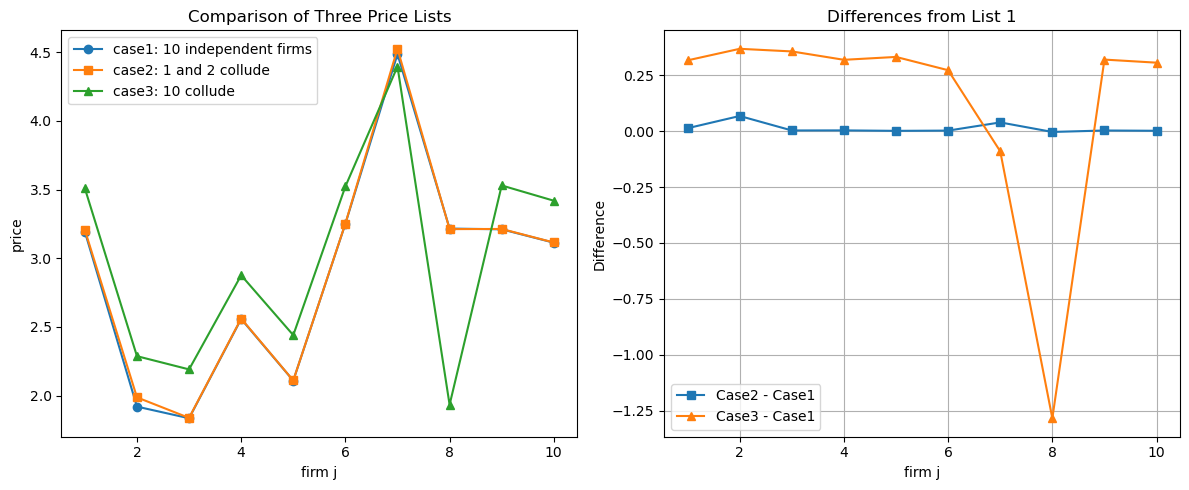

In [23]:
paint(price_star,price_star_q2,price_star_q3)

It make sense that the collusion between 1 and 2 won't change their pricing a lot, since their market share is really small (6%). 2 is extremely small (2% of the market share of 1), so one should expect there is no much change for 1's pricing.

In [24]:
market_share_list100 = list(data[data['t']==100]['market_share'])
market_share_list100[0]+market_share_list100[1], market_share_list100[1]/market_share_list100[0]

(0.0643196930883229, 0.022078011064517768)

In [25]:
def calc_profit(temp_price):
    s_list = share_function_MNL(temp_price)
    pi=[0]
    for j in range(1, 11):
        #print(j,temp_price[j-1],c_jt_dic[(j,Temp_t)],s_list[j-1])
        pi.append((temp_price[j-1]-c_jt_dic[(j,Temp_t)])*(s_list[j-1]))
    return pi

def loss_total_profit(p):
    return -1 * np.sum(calc_profit(p))

# step 2: I directly search for optimal p vector that maximizes the total profit. It gives an almost perfect answer, but since the tolerance is quite high, I just use it as a clever initial guess for Nash solver (GMM).
initial_guess=list(data[data['t']==100]['price'])
result = minimize(loss_total_profit, initial_guess, tol=1e-4,method = 'Nelder-Mead')
paint(price_star,price_star_q2,result.x)

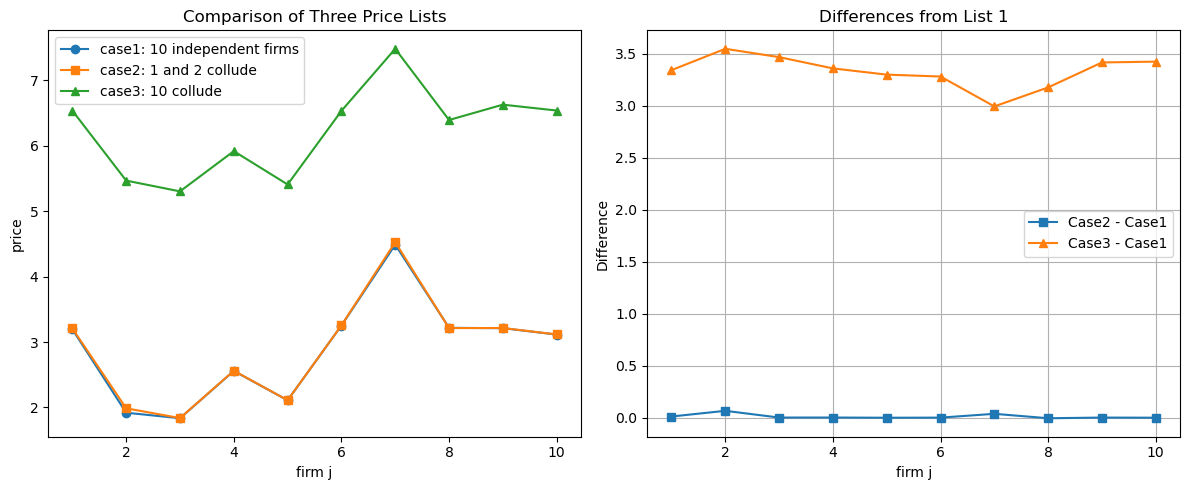

number of iterations for minimize kernal: 805


In [27]:
# step 3: Use theory_optimal_price as an initial guess for GMM solver. Finally I get price_star_q3_prime which is even better than theory_xx.
optimal_profit = np.sum(calc_profit(result.x))
global theory_optimal_price
theory_optimal_price = result.x

price_star_q3_prime,result_q3_prime = solve_Nash(initial_guess=theory_optimal_price, question=3)
paint(price_star,price_star_q2,price_star_q3_prime)
# and the optimal price_star for 10-collusion is price_star_q3_prime
print(price_star_q3_prime) 

In [31]:
pi_q1=calc_profit(price_star)
pi_q2=calc_profit(price_star_q2)
pi_q3=calc_profit(price_star_q3_prime)
pi_q3_prime=calc_profit(price_star_q3_prime)
judge_q2profitable = pi_q1[1]+pi_q1[2]<=pi_q2[1]+pi_q2[2]
judge_q3profitable = np.sum(pi_q1)<= np.sum(pi_q3)

print(judge_q2profitable, (pi_q2[1]+pi_q2[2])/pi_q1[1]+pi_q1[2])
print(judge_q3profitable, np.sum(pi_q3)/np.sum(pi_q1))
# So my results say :
# If 1 and 2 collude then both firm's profit increases by 20%
# If all firms collude then the total profit increases by 237%.


True 1.2482128544359468
True 3.3763327303039574
